**Import Libraries and Define constants**

In [2]:
#### Training based on features of audio
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sknn.mlp import Classifier, Layer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import random
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots_adjust



WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\THEDE\Miniconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.1

In [ ]:
a = np.array([1.5,1,1,1,1.5])
print(a)
[ e >1 for e in a ]

**Load data**

In [17]:
##Loading  data from files
filehandlerInput = open('processed-data/input_VAD.obj', 'rb')
filehandlerOutput = open('processed-data/output_VAD.obj', 'rb')
input = pickle.load(filehandlerInput)
output = pickle.load(filehandlerOutput)
print("Size input, output:", len(input),", ", len(output))


Size input, output: 10018 ,  10018


**Preprocess data and Analyze data**

Distinct output:  {0.5, 1.5, 2.5, 3.5, 3.0, 4.0, 2.0, 4.5, 5.0, 1.0, 2.3333, 2.6667, 4.3333, 2.25, 2.75, 3.25, 3.75, 4.75, 4.25, 5.5, 1.3333, 3.3333, 4.6667, 1.6667, 3.6667}
Average labels: 2.7782824016769814
Std labels: 0.8970523348000802

Distinct output:  {0, 1, 2, 3, 4, 5, 6}
Average labels: 2.7481533240167697
Std labels: 0.9153419863285778


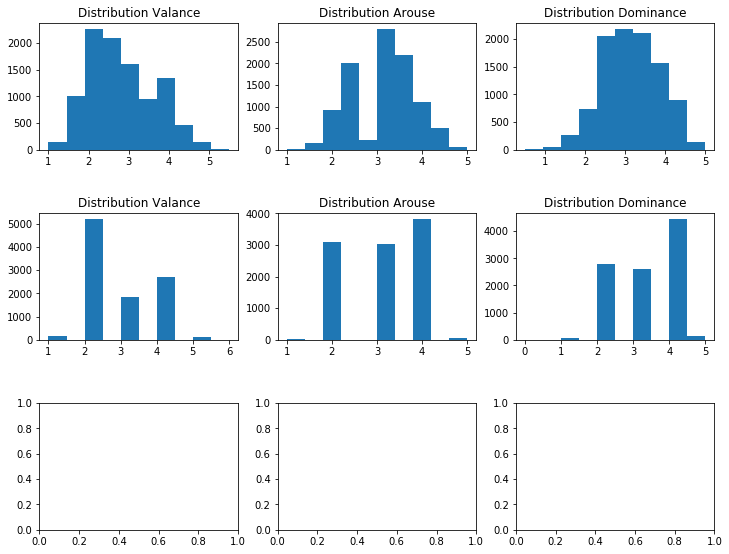

In [18]:
# removing_label = np.array([0.5, 1.5, 2.5, 3.5])
# remove_condition = np.array([True for o in output if o in removing_label])
                            
# print(remove_condition)
# input = input[~remove_condition]
# output = output[~remove_condition]

fig, axs = plt.subplots(3,3, figsize=(5,8))
subplots_adjust(right = 2, wspace=0.2, hspace=0.5, bottom=0)


## Draw distribution of raw output
flattened_out = output.flatten()
print("Distinct output: ", set(flattened_out));
print("Average labels:", np.average(output[:,0]))
print("Std labels:", np.std(output[:,0]))
axs[0][0].hist(output[:,0])
axs[0][0].set_title("Distribution Valance")
axs[0][1].hist(output[:,1])
axs[0][1].set_title("Distribution Arouse")
axs[0][2].hist(output[:,2])
axs[0][2].set_title("Distribution Dominance")





## Around output into integer.
for i in range(0, output.size):
    output.flat[i] = int(np.round(output.flat[i]))
output = output.astype(int)

flattened_out = output.flatten()
print("\nDistinct output: ", set(flattened_out));
print("Average labels:", np.average(output[:,0]))
print("Std labels:", np.std(output[:,0]))
axs[1][0].hist(output[:,0])
axs[1][0].set_title("Distribution Valance")
axs[1][1].hist(output[:,1])
axs[1][1].set_title("Distribution Arouse")
axs[1][2].hist(output[:,2])
axs[1][2].set_title("Distribution Dominance")
plt.show()


**Preprocess data**

In [21]:
from keras.utils.np_utils import to_categorical

input_filtered = input[~np.any(np.isnan(input), axis=1)]
input_filtered = input_filtered[:,0:88]
output_filtered = output[~np.any(np.isnan(input), axis=1)]
print("Size input, output after remove Nan values ", len(input_filtered), ", ", len(output_filtered))

#Normalize input
input_filtered = (input_filtered - input_filtered.min(axis=0)) / (input_filtered.max(axis=0) - input_filtered.min(axis=0))

#Normalize output
def categorize_output(output):
    if (output <= 2.5):
        return 0
    elif  output >= 4:
        return 2
    else:
        return 1

# def categorize_output(output):
#     return np.around(output)
   
print(output_filtered.shape)

output_filtered = np.array([list(map(lambda x: categorize_output(x), col)) for col in output_filtered])
#pprint(output_filtered)
#output_filtered = [to_categorical(out, 6) for out in output_filtered]
#output_filtered = (output_filtered - output_filtered.min(axis=0)) / (output_filtered.max(axis=0) - output_filtered.min(axis=0))
print("Normalize input and categorize output ")
print(len(output_filtered))



Size input, output after remove Nan values  10009 ,  10009
(10009, 3)
Normalize input and categorize output 
10009


**Shuffer data**

In [22]:
#Shuffer
c = list(zip(input_filtered, output_filtered))
random.shuffle(c)
input_filtered, output_filtered = zip( * c)
input_filtered = np.array(input_filtered)
output_filtered = np.array(output_filtered)
print(output_filtered)

[[0 2 2]
 [0 2 2]
 [0 1 0]
 ...
 [1 1 1]
 [0 0 0]
 [0 0 2]]


**Split data**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(input_filtered, output_filtered, test_size=0.2, random_state=300)
print("Size training, testing set: ", len(X_train), ", ", len(X_test))



Size training, testing set:  8007 ,  2002


**Filter only integer values**

In [ ]:
def create_filter_condition_int(arr):
    return [int(el) - el == 0 for el in arr]

filter_condition_arouse_train = create_filter_condition_int(y_train[:,1])
filter_condition_arouse_test = create_filter_condition_int(y_test[:,1])
X_train = X_train[filter_condition_arouse_train]
y_train = y_train[filter_condition_arouse_train]
X_test = X_test[filter_condition_arouse_test]
y_test = y_test[filter_condition_arouse_test]

print('Size train and test after filter integer values ', len(X_train), len(X_test) )

**Training on keras**

In [10]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
import tensorflow as tf

with tf.device('/device:CPU:0'):
#     model = Sequential([
#         Dense(64, input_shape=(20,), kernel_initializer='normal'),
#        Activation('relu'),
#         Dense(32, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(16,kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(8, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(1,kernel_initializer='normal'),
#     ])
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X_train, y_train[:,0], validation_data=(X_test, y_test[:,0]), epochs = 20)
    #model.fit(X_train[0:2], y_train[0:2,0], validation_data=(X_test[0:2], y_test[0:2,0]), epochs = 1000)

        
    
    

    model1 = Sequential([
        Dense(64, input_shape=(88,), kernel_initializer='normal'),
        Activation('relu'),
        Dense(32, kernel_initializer='normal'),
        Activation('relu'),
        Dense(16,kernel_initializer='normal'),
        Activation('relu'),
        Dense(8, kernel_initializer='normal'),
        Activation('relu'),
        Dense(3),
        Activation('softmax'),

    ])
    model1.compile(loss='categorical_crossentropy', optimizer='adam')
    
    model1.fit(X_train, y_train[:,1], validation_data=(X_test, y_test[:,1]), epochs = 50)


#     model2 = Sequential([
#         Dense(64, input_shape=(20,), kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(32, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(16,kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(8, kernel_initializer='normal'),
#         Activation('relu'),
#         Dense(1),
#     ])
#     model2.compile(loss='mean_squared_error', optimizer='adam')
#     model2.fit(X_train, y_train[:,2], validation_data=(X_test, y_test[:,2]), epochs = 20)



Train on 8007 samples, validate on 2002 samples
Epoch 1/50
8007/8007 [==============================] - ETA: 2:29 - loss: 1.098 - ETA: 3s - loss: 1.0953  - ETA: 1s - loss: 1.088 - ETA: 0s - loss: 1.076 - ETA: 0s - loss: 1.060 - ETA: 0s - loss: 1.037 - ETA: 0s - loss: 1.013 - 1s 133us/step - loss: 1.0090 - val_loss: 0.9012
Epoch 2/50
8007/8007 [==============================] - ETA: 0s - loss: 1.052 - ETA: 0s - loss: 0.868 - ETA: 0s - loss: 0.880 - ETA: 0s - loss: 0.898 - ETA: 0s - loss: 0.894 - ETA: 0s - loss: 0.894 - 0s 40us/step - loss: 0.8941 - val_loss: 0.8889
Epoch 3/50
8007/8007 [==============================] - ETA: 0s - loss: 0.797 - ETA: 0s - loss: 0.875 - ETA: 0s - loss: 0.873 - ETA: 0s - loss: 0.876 - ETA: 0s - loss: 0.876 - ETA: 0s - loss: 0.878 - 0s 38us/step - loss: 0.8805 - val_loss: 0.8838
Epoch 4/50
8007/8007 [==============================] - ETA: 0s - loss: 0.911 - ETA: 0s - loss: 0.890 - ETA: 0s - loss: 0.879 - ETA: 0s - loss: 0.875 - ETA: 0s - loss: 0.878 - ETA: 0

8007/8007 [==============================] - ETA: 0s - loss: 0.680 - ETA: 0s - loss: 0.848 - ETA: 0s - loss: 0.840 - ETA: 0s - loss: 0.850 - ETA: 0s - loss: 0.842 - ETA: 0s - loss: 0.842 - 0s 37us/step - loss: 0.8438 - val_loss: 0.8774
Epoch 32/50
8007/8007 [==============================] - ETA: 0s - loss: 0.892 - ETA: 0s - loss: 0.843 - ETA: 0s - loss: 0.841 - ETA: 0s - loss: 0.840 - ETA: 0s - loss: 0.841 - ETA: 0s - loss: 0.841 - 0s 39us/step - loss: 0.8428 - val_loss: 0.8575
Epoch 33/50
8007/8007 [==============================] - ETA: 0s - loss: 0.863 - ETA: 0s - loss: 0.849 - ETA: 0s - loss: 0.845 - ETA: 0s - loss: 0.846 - ETA: 0s - loss: 0.844 - ETA: 0s - loss: 0.840 - ETA: 0s - loss: 0.840 - ETA: 0s - loss: 0.841 - 0s 52us/step - loss: 0.8430 - val_loss: 0.8605
Epoch 34/50
8007/8007 [==============================] - ETA: 0s - loss: 0.902 - ETA: 0s - loss: 0.832 - ETA: 0s - loss: 0.849 - ETA: 0s - loss: 0.840 - ETA: 0s - loss: 0.844 - ETA: 0s - loss: 0.839 - ETA: 0s - loss: 0.8

**Ordinal logistic regression**

In [24]:
import mord
from sklearn import linear_model, metrics, preprocessing

clf2 = mord.LogisticAT(alpha=1)
#clf2 = mord.LogisticIT(alpha=1)
#clf2 = mord.LAD()
#clf2 = mord.OrdinalRidge()
#clf2 = mord.MulticlassLogistic()

y_train_AT = y_train 
y_train_AT = y_train_AT.astype(int)
y_test_AT = y_test.astype(int)

clf2.fit(X_train, y_train_AT[:,1] )

print(metrics.mean_absolute_error(model1.predict(X_test), y_test_AT[:,1]))
print('Mean Absolute Error of LogisticAT %s' % metrics.mean_absolute_error(clf2.predict(X_test), y_test_AT[:,1]))

print(clf2.predict(X_test)[0:3])
#print(clf2.predict_proba(X_test)[0:3])


ValueError: y_true and y_pred have different number of output (3!=1)

**Coefficient of Determination**

In [ ]:
from sklearn.metrics import r2_score

#predict = model.predict(X_test)
predict1 = model1.predict(X_test)
#predict2 = model2.predict(X_test)

# a = r2_score(y_test[:,0], predict)
# print("The R2 for Valance: " ,a)

a1 = r2_score(y_test[:,1], predict1)
print("The R2 for Activation: " ,a1)

# a2 = r2_score(y_test[:,2], predict2)
# print("The R2 for Dominance: " ,a2)


**Distribution of err**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(0, 1, 10)
data = np.abs(predict1 - y_test[:,1])
print(len(data))
hist, bin_edges = np.histogram(data,bins) # make the histogram
print(hist)

fig,ax = plt.subplots()

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1) 

# # Set the ticks to the middle of the bars
# ax.set_xticks([0.5+i for i,j in enumerate(hist)])

# # # Set the xticklabels to a string that tells us what the bin edges were
# # ax.set_xticklabels(['{} - {}'.format(bins[i],bins[i+1]) for i,j in enumerate(hist)])

plt.show()


#predict = model.predict(X_test)

#plt.hist(subs, bins =bins)

**Standard residual plot**

In [ ]:
import seaborn as sns
from matplotlib.pyplot import subplots_adjust
sns.set(style="whitegrid")

fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
predict = model.predict(X_test)
predict = np.array([p[0] for p in predict])
axs[0] = sns.residplot(y_test[:,0], predict, lowess=True, color="g", ax=axs[0])
axs[0].set_ylim([-0.4,0.4])
axs[0].set_title("Residual for Valance") 


predict1 = model1.predict(X_test)
predict1 = np.array([p[0] for p in predict1])
axs[1] = sns.residplot(y_test[:,1], predict1, lowess=True, color="r", ax=axs[1])
axs[1].set_ylim([-0.4,0.4])
axs[1].set_title("Residual for Activation")

predict2 = model2.predict(X_test)
predict2 = np.array([p[0] for p in predict2])
axs[2] = sns.residplot(y_test[:,2], predict2, lowess=True, color="b", ax=axs[2])
axs[2].set_ylim([-0.5,0.5])
axs[2].set_title("Residual for Dominance")


plt.show()
plt.close()


The residual plot show that the error followed random pattern. If the residual plot is not enough random, then the model would be likely to lose something. 

**Playing around with prediction**

In [ ]:

predict = model.predict(X_test)
#print(predict)

subs = np.abs(predict - y_test[:,0])


fig, axs = plt.subplots(1,3)
subplots_adjust(right = 2, wspace=0.2)
axs[0].hist(y_train[:,0])
axs[0].set_title("True value in train data\n" + 
                 "avg:" + str(np.average(y_train[:,0])) + 
                 "\nstd:" + str(np.std(y_train[:,0])))
axs[1].hist(y_test[:,0])
axs[1].set_title("True value in test data\n" + 
                 "avg:" + str(np.average(y_test[:,0])) + 
                 "\nstd:" + str(np.std(y_test[:,0])))
axs[1].set_ylim([0,400])
                        
axs[2].hist(predict) 
axs[2].set_title("Prediction\n" +
                "avg:" + str(np.average(predict)) + 
                 "\nstd:" + str(np.std(predict)))
                
# axs[2].hist(subs, bins='auto')
# axs[2].set_title("error on predictions")

plt.show()
plt.close()


In [ ]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

predict = model1.predict(X_test)
bins = np.linspace(0, 1, 6)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)

# y = y_test[:,1]
# subs = np.abs(y-predict)
# print("ave, std, per90:", np.average(subs), ", ", np.std(subs), ",", np.percentile(subs, 60))
    
for r in bin_ranges:
    # Get valance
    y = y_test[:,1]
    condition1 = [r[0] <= e <= r[1]for e in y]
    
    predict = predict.flatten()
    condition2 = [r[0] <= e <= r[1]for e in predict]
    
    y = y[condition1 or condition2]
    pre = predict[condition1 or condition2]
    #pre= pre.flatten()
    #print(pre)
    subs = np.abs(y-pre)
   # print(subs)
    try:
        #print(subs)
        print("\nIn range " , r, 
              "\nNum samples: ", len(subs),
              "\nAverage err: ", np.average(subs), 
              "\nStd err: ", np.std(subs),
              "\nMedian err: ", np.median(subs), 
             "\nPercentile: ", np.percentile(subs, 90),
              "\nConfident Interval: ", mean_confidence_interval(subs)
             )
    except:
        print("null array")

    

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.99):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

predict = clf2.predict(X_test)
bins = np.linspace(0, 6, 7)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)


for r in bin_ranges:
    # Get valance
    y = y_test[:,1]
    condition1 = [r[0] <= e <= r[1]for e in y]
    
    predict = predict.flatten()
    condition2 = [r[0] <= e <= r[1]for e in predict]
    
    y = y[condition1 or condition2]
    pre = predict[condition1 or condition2]
    #pre= pre.flatten()
    print(pre)
    subs = np.abs(y-pre)
   # print(subs)
    try:
        print(subs)
        print("\nIn range " , r, 
              "\nNum samples: ", len(subs),
              "\nAverage err: ", np.average(subs), 
              "\nStd err: ", np.std(subs),
              "\nMedian err: ", np.median(subs), 
             "\nPercentile: ", np.percentile(subs, 95),
              "\nConfident Interval: ", mean_confidence_interval(subs)
             )
    except:
        print("null array")

    

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt


predict = model.predict(X_test)
predict = np.array([p[0] for p in predict])

predict1 = model1.predict(X_test)
predict1 = np.array([p[0] for p in predict1])

predict2 = model2.predict(X_test)
predict2 = np.array([p[0] for p in predict2])

fig, ax = plt.subplots()
ax.scatter(y_test[:,1], predict1, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

# ax[1].scatter(y_test[:,1], predict, edgecolors=(0, 0, 0))
# ax[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
# ax[1].set_xlabel('Actual')
# ax[1].set_ylabel('Predicted')

# ax[2].scatter(y_test[:,2], predict, edgecolors=(0, 0, 0))
# ax[2].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
# ax[2].set_xlabel('Actual')
# ax[2].set_ylabel('Predicted')

plt.show()

**Playing around **

In [ ]:
from functools import reduce
predict = model2.predict(X_test)

def reducer(acc, val):
    if (val > 0.5):
        acc = acc + 1
    return acc

num = reduce(lambda acc,val: acc+1 if val >1 else acc, predict.flatten(), 0) 
print(num)

**Confidence in interval for Arouse**

[1 1 2 ... 2 1 0]
Confusion matrix: 
 [[335 252  40]
 [105 349 151]
 [ 29 269 472]]
Num samples: 1232
Accurcy in range:  [0. 1.] :  0.5547445255474452
Num samples: 1375
Accurcy in range:  [1. 2.] :  0.596656976744186
Num samples: 770
Accurcy in range:  [2. 3.] :  0.6121919584954605
Num samples: 0
Accurcy in range:  [3. 4.] :  0.0
Num samples: 0
Accurcy in range:  [4. 5.] :  0.0
{0, 1, 2}
2002


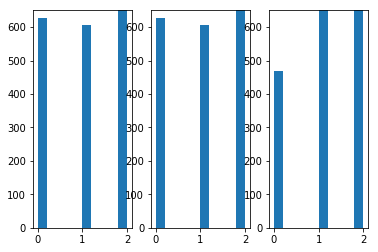

In [28]:
predict = clf2.predict(X_test)
print(predict)
#predict = clf2.predict(X_test)
#print(predict)
#predict = np.array([p[0] for p in predict])
y = y_test[:, 1]
y1=y
#y1 = np.argmax(y,1)
cm = confusion_matrix(y1, predict)
print("Confusion matrix: \n", cm)


bins = np.linspace(0, 5, 6)
bin_ranges = [bins[i-1: i+1] for i in range (1,len(bins))]
bin_ranges =  np.array(bin_ranges)

for r in bin_ranges:
     condition = [r[0] <= e <= r[1] for e in y]
     y1 = y[condition]
     pre = predict.flatten()
     pre = pre[condition]
     num_true = 0
     for i in range (0, len(y1)):
        if (np.abs(y1[i] - pre[i]) ==0 ):
            num_true += 1
     print("Num samples:", len(pre))
     print("Accurcy in range: ", r, ": ", num_true / (len(pre) +1 ) )
            

fig, ax = plt.subplots(1,3)
y_int = y.astype(int)

ax[0].hist(y)
ax[0].set_ylim([0,650])
ax[1].hist(y_int)
ax[1].set_ylim([0,650])
ax[2].hist(predict)
ax[2].set_ylim([0,650])
        
print(set(predict))
print(len(predict))



### 